### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
%%time

##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('data/cleaned_data.csv')

print(dataset.shape)

(238964, 13)
CPU times: total: 312 ms
Wall time: 329 ms


In [4]:
# drop the data column as it is not needed for training
dataset.drop(['created_date'], axis=1, inplace=True)

In [5]:
dataset.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


### 3 Setting up Environment 

#### 3.1. Create database

In [18]:
# create a connection and setup a SQLite database with the name "model_experimentation" in 
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection("model_experimentation.db")

2.6.0


In [7]:
# create a mlflow tracking uri at "port 6007"
mlflow.set_tracking_uri("http://localhost:6007")

In [8]:
# setup pycaret 
exp_lead_scoring = setup(
    data=dataset, target = 'app_complete_flag',  
    fold_shuffle=True,session_id = 42, normalize = True,transformation = True, 
    remove_multicollinearity = True, multicollinearity_threshold = 0.95,
    n_jobs=-1,
    # use_gpu=True, 
    log_experiment=True,log_plots=True, log_data=True, verbose=True, log_profile=False,
    experiment_name='model_experimentation',
)

,Description,Value
0,Session id,42
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(238964, 12)"
4,Transformed data shape,"(238964, 44)"
5,Transformed train set shape,"(167274, 44)"
6,Transformed test set shape,"(71690, 44)"
7,Numeric features,8
8,Categorical features,3
9,Preprocess,True


### 4 : Model Experimentation with pycaret

In [9]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7381,0.8203,0.8331,0.7014,0.7616,0.4758,0.4845,5.8520
rf,Random Forest Classifier,0.7368,0.8172,0.8201,0.7043,0.7578,0.4733,0.4799,10.4920
et,Extra Trees Classifier,0.7360,0.8160,0.8168,0.7044,0.7565,0.4716,0.4778,12.4940
dt,Decision Tree Classifier,0.7357,0.8152,0.8164,0.7042,0.7562,0.4710,0.4771,5.3960
lr,Logistic Regression,0.7135,0.7897,0.8006,0.6832,0.7373,0.4266,0.4332,5.3420
ridge,Ridge Classifier,0.7098,0.0000,0.8174,0.6740,0.7388,0.4190,0.4289,4.3600
lda,Linear Discriminant Analysis,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,5.1880
nb,Naive Bayes,0.6780,0.7376,0.8509,0.6335,0.7263,0.3551,0.3784,4.8800


In [10]:
# create a model which gives the highest accuracy

lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7363,0.8168,0.8327,0.6994,0.7602,0.4722,0.4811
1,0.7369,0.8184,0.8317,0.7004,0.7604,0.4734,0.4820
2,0.7448,0.8269,0.8363,0.7082,0.7669,0.4892,0.4975
3,0.7417,0.8230,0.8356,0.7048,0.7646,0.4830,0.4916
4,0.7393,0.8207,0.8376,0.7012,0.7634,0.4781,0.4875
5,0.7377,0.8218,0.8297,0.7020,0.7605,0.4749,0.4831
6,0.7382,0.8193,0.8329,0.7015,0.7616,0.4760,0.4847
7,0.7344,0.8176,0.8290,0.6984,0.7581,0.4683,0.4768
8,0.7358,0.8200,0.8415,0.6959,0.7618,0.4712,0.4819


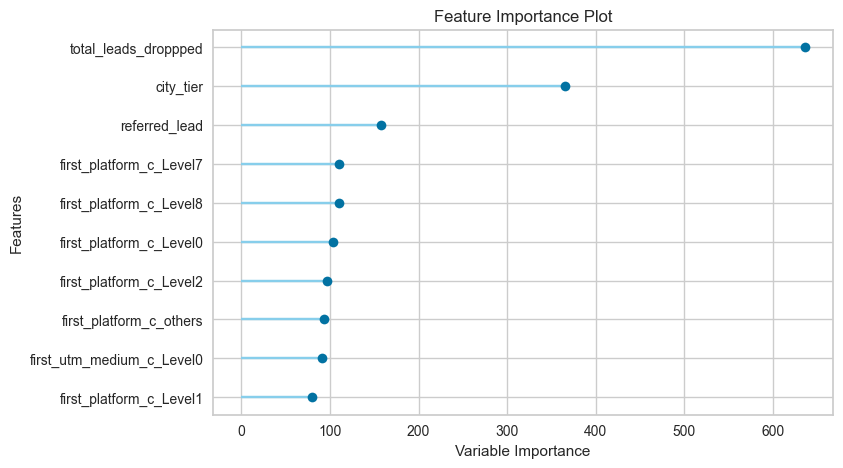

In [11]:
# create feature importance plot
plot_model(lightgbm, plot='feature')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [12]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c', 'app_complete_flag']
dataset_cols = dataset[cols]

In [13]:
from pycaret.classification import *

exp_lead_scoring = setup(
    data=dataset_cols, target = 'app_complete_flag',
    remove_multicollinearity = True, multicollinearity_threshold = 0.95,
    categorical_features = ['city_tier', 'first_platform_c','first_utm_medium_c', 'first_utm_source_c'],fold_shuffle=True,session_id = 42,n_jobs=-1,
    # use_gpu=True,
    log_experiment=True,experiment_name='model_experimentation_02',log_plots=True, log_data=True, verbose=True,log_profile=False,
)

,Description,Value
0,Session id,42
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(238964, 7)"
4,Transformed data shape,"(238964, 41)"
5,Transformed train set shape,"(167274, 41)"
6,Transformed test set shape,"(71690, 41)"
7,Numeric features,2
8,Categorical features,4
9,Preprocess,True


In [14]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 10,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7380,0.8204,0.8345,0.7008,0.7618,0.4755,0.4845,1.6000
rf,Random Forest Classifier,0.7374,0.8178,0.8221,0.7044,0.7587,0.4745,0.4813,6.3150
et,Extra Trees Classifier,0.7367,0.8168,0.8181,0.7049,0.7573,0.4730,0.4793,7.6250
dt,Decision Tree Classifier,0.7364,0.8161,0.8176,0.7047,0.7569,0.4724,0.4787,1.0060
lr,Logistic Regression,0.7090,0.7834,0.8177,0.6730,0.7383,0.4175,0.4276,1.7630
ridge,Ridge Classifier,0.6992,0.0000,0.7937,0.6689,0.7260,0.3979,0.4051,0.8310
lda,Linear Discriminant Analysis,0.6992,0.7725,0.7937,0.6689,0.7260,0.3979,0.4051,1.2050
nb,Naive Bayes,0.6734,0.7337,0.8550,0.6284,0.7244,0.3458,0.3711,0.8460


In [15]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm_fs = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7350,0.8164,0.8392,0.6957,0.7608,0.4695,0.4800
1,0.7365,0.8180,0.8379,0.6979,0.7615,0.4727,0.4826
2,0.7449,0.8270,0.8372,0.7080,0.7672,0.4894,0.4979
3,0.7418,0.8230,0.8363,0.7046,0.7648,0.4831,0.4918
4,0.7388,0.8208,0.8310,0.7029,0.7616,0.4772,0.4854
5,0.7383,0.8218,0.8325,0.7018,0.7616,0.4762,0.4848
6,0.7377,0.8193,0.8277,0.7028,0.7601,0.4751,0.4828
7,0.7343,0.8175,0.8291,0.6983,0.7581,0.4682,0.4768
8,0.7359,0.8197,0.8423,0.6957,0.7620,0.4713,0.4822


In [16]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm_optuna,tuner_1 = tune_model(lightgbm_fs, 
                                   search_library = 'optuna',
                                   fold = 10,
                                   optimize = 'auc',
                                   choose_better = True, 
                                   return_tuner=True
                                )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7297,0.8151,0.8866,0.6759,0.7671,0.4587,0.4830
1,0.7327,0.8168,0.8854,0.6793,0.7688,0.4647,0.4879
2,0.7412,0.8256,0.8785,0.6904,0.7732,0.4818,0.5010
3,0.7367,0.8211,0.8764,0.6861,0.7697,0.4727,0.4922
4,0.7337,0.8191,0.8814,0.6815,0.7687,0.4667,0.4884
5,0.7373,0.8205,0.8743,0.6875,0.7697,0.4740,0.4928
6,0.7335,0.8184,0.8871,0.6798,0.7697,0.4664,0.4900
7,0.7325,0.8155,0.8709,0.6832,0.7657,0.4643,0.4831
8,0.7311,0.8179,0.8870,0.6773,0.7681,0.4615,0.4856


[I 2023-12-28 16:44:12,749] Searching the best hyperparameters using 167274 samples...
[I 2023-12-28 16:49:15,253] Finished hyperparameter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [17]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
